In [ ]:
!pip install langgraph==0.0.68
!pip install langchain==0.2.14
!pip install langchain-openai==0.1.8
!pip install langchainhub==0.1.20
!pip install tiktoken==0.7.0

In [ ]:
import os
import getpass

# # Set OPENAI API Key

os.environ["OPENAI_API_KEY"] = getpass.getpass()
os.environ["TAVILY_API_KEY"] = getpass.getpass() # you can obtain your tavily api key here: https://tavily.com/
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass() # obtain your langsmith api key here: https://smith.langchain.com/settings
# OR (load from .env file)
# make sure you have python-dotenv installed
# from dotenv import load_dotenv
# load_dotenv("./.env")

# Basics of LangGraph

check out the langgraph docs here: 

- https://langchain-ai.github.io/langgraph/concepts/#background-agents-ai-workflows-as-graphs

LangGraph models agent workflows as state machines. You define the behavior of your agents using three key components:

- State: A shared data structure that represents the current snapshot of your application. It can be any Python type, but is typically a TypedDict or Pydantic BaseModel.

- Nodes: Python functions that encode the logic of your agents. They receive the current State as input, perform some computation or side-effect, and return an updated State.

- Edges: Control flow rules that determine which Node to execute next based on the current State. They can be conditional branches or fixed transitions.

By composing Nodes and Edges, you can create complex, looping workflows that evolve the State over time. The real power, though, comes from how LangGraph manages that State.

The graph orchestrates everything:

The MessageGraph contains the agent's "Memory"
Conditional edges enable dynamic routing between the chatbot, tools, and the user.

Persistence makes it easy to stop, resume, and even rewind for full control over your application

With LangGraph, you can build complex, stateful agents by just defining your nodes, edges, and state schema - the graph take care of the rest.

In [11]:
# source: https://langchain-ai.github.io/langgraph/#example
# only changed the model being used

from typing import Annotated, Literal, TypedDict

from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode


# Define the tools for the agent to use
@tool
def search(query: str):
    """Call to surf the web."""
    # This is a placeholder, but don't tell the LLM that...
    if "sf" in query.lower() or "san francisco" in query.lower():
        return "It's 60 degrees and foggy."
    return "It's 90 degrees and sunny."


tools = [search]

tool_node = ToolNode(tools)

model = ChatOpenAI(model='gpt-4o', temperature=0).bind_tools(tools)

# Define the function that determines whether to continue or not
def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state['messages']
    last_message = messages[-1]
    # If the LLM makes a tool call, then we route to the "tools" node
    if last_message.tool_calls:
        return "tools"
    # Otherwise, we stop (reply to the user)
    return END


# Define the function that calls the model
def call_model(state: MessagesState):
    messages = state['messages']
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define a new graph
workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("tools", 'agent')

# Initialize memory to persist state between graph runs
checkpointer = MemorySaver()

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable.
# Note that we're (optionally) passing the memory when compiling the graph
app = workflow.compile(checkpointer=checkpointer)

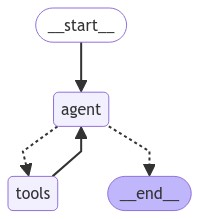

In [12]:
from IPython.display import Image


Image(app.get_graph().draw_mermaid_png())

In [13]:
# Use the Runnable
final_state = app.invoke(
    {"messages": [HumanMessage(content="what is the weather in sf")]},
    config={"configurable": {"thread_id": 42}}
)
final_state["messages"][-1].content

'The current weather in San Francisco is 60 degrees and foggy.'